In [1]:
# !pip install -e ..

In [18]:
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

from generation.config import SIGNAL_DIM, DETECTORS, POSTPROCESSED_SIGNALS_PATH
from generation.dataset.data_utils import get_detector_training_data


class MyDataset(Dataset):
    def __init__(self, detectors=DETECTORS, signal_dim=SIGNAL_DIM, freq=1):
        self.detectors = detectors
        self.signal_dim = signal_dim
        self.freq = freq
        
        self.signals = np.load(POSTPROCESSED_SIGNALS_PATH)       
        self.amplitudes = self._get_amplitudes()
        self.ref_times = self._get_ref_times()
        
    def _get_signals(self):
        signals = []
        for detector in self.detectors:
            signals.append(get_detector_training_data(detector))
        signals = np.array(signals)[:, :, :self.freq * self.signal_dim:self.freq]
        return signals

    def _get_amplitudes(self):
        amplitudes = np.max(self.signals, axis=2)
        amplitudes /= np.max(amplitudes, axis=1)[:, None]
        return amplitudes
    
    def _get_ref_times(self):
        ref_times = np.zeros(self.amplitudes.shape)
        for detector_idx in range(ref_times.shape[0]):
            for signal_idx in range(ref_times.shape[1]):
                ref_times[detector_idx][signal_idx] = self._get_ref_time_pred(signals[detector_idx][signal_idx])
        np.nan_to_num(ref_times, 0)
        return ref_times
        
    @staticmethod
    def _get_ref_time_pred(signal):
        half_amplitude = np.min(signal) + (np.max(signal) - np.min(signal)) / 2
        for idx, cur_amplitude in enumerate(signal):
            if cur_amplitude > half_amplitude:
                return idx

    def __len__(self):
        return self.signals.shape[1]

    def __getitem__(self, idx):
        detector_times = self.ref_times[:, idx]
        detector_amplitudes = self.amplitudes[:, idx]
        
        features = np.concatenate([detector_times, detector_amplitudes], axis=0)
        
        tensor = torch.from_numpy(features)
        return tensor.float()


In [19]:
dataset = MyDataset()

In [21]:
dataset[0]

torch.Size([18])

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb

from generation.nets.abstract_net import AbstractGenerator, AbstractDiscriminator


class Generator(AbstractGenerator):
    def __init__(self, config):
        super(Generator, self).__init__(config)
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']

        self.fc1 = nn.Linear(self.z_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        
        self.time_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, self.x_dim // 2)
        )
        
        self.amplitude_head = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, self.x_dim // 2)
        )
        

    def forward(self, x, debug=False):
        # [batch_size, 32]
        x = F.relu(self.fc1(x))
        # [batch_size, 64]
        x = F.relu(self.fc2(x))
        # [batch_size, 2, 32]
        x = x.view(x.shape[0], 2, -1)
        
        # [batch_size, 32]
        time_features = x[:, 0]
        # [batch_size, 32]
        amplitude_features = x[:, 1]
        
        times = self.time_head(time_features)
        amplitudes = self.amplitude_head(amplitude_features)
        
        return torch.cat([times, amplitudes], dim=1)
        
        
    @staticmethod
    def get_rel_fake_fig(real_sample, fake_sample):
        real_sample = real_sample.cpu().data
        fake_sample = fake_sample.cpu().data

        plt.clf()
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].set_title("Real")
        ax[0].plot(real_sample)
        ax[1].set_title("Fake")
        ax[1].plot(fake_sample)
        return fig


class Discriminator(AbstractDiscriminator):
    def __init__(self, config):
        super(Discriminator, self).__init__(config)
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']

        self.fc1 = nn.Linear(self.x_dim, self.x_dim)
        self.fc2 = nn.Linear(self.x_dim, (self.x_dim + self.z_dim) // 2)
        self.fc3 = nn.Linear((self.x_dim + self.z_dim) // 2, 1)

    def forward(self, x, debug=False):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [62]:
config = {
    "g_lr": 3e-4,
    "d_lr": 1e-4,
    "epochs_num": 1000,
    "batch_size": 32,
    "log_each": 5,
    "decay_epoch": 0,
    "save_each": 2,
    "device": "cuda:1",
    "x_dim": 18,
    "z_dim": 64,
    "d_coef": 5,
    "use_gp": True,
    "clip_value": 0.01,
    "lambda": 10,
    "channels": 64,
    "pad_size": 9,
    "g_use_scheduler": False,
    "g_lr_multiplier": 5,
    "g_lr_total_epoch": 200,
    "d_use_scheduler": False,
    "d_lr_multiplier": 5,
    "d_lr_total_epoch": 200,
    "g_beta1": 0,
    "g_beta2": 0.99,
    "d_beta1": 0,
    "d_beta2": 0.99
}

In [63]:
generator = Generator(config)
discriminator = Discriminator(config)

z = torch.zeros([10, config['z_dim']])
discriminator(generator(z))
discriminator(dataset[0].unsqueeze(0))

tensor([[-5.0301]], grad_fn=<AddmmBackward>)

wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1000 [00:03<?, ?it/s]


ValueError: axes don't match array

<Figure size 432x288 with 0 Axes>

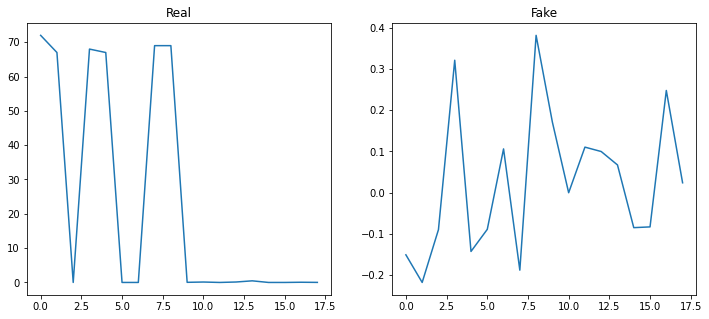

In [64]:
import torch

from generation.training.wgan_trainer import WganTrainer
from generation.utils import set_seed

dataset = MyDataset(signals)
generator = Generator(config)
discriminator = Discriminator(config)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['g_lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['d_lr'])

trainer = WganTrainer(generator, discriminator, g_optimizer, d_optimizer, config)
trainer.run_train(dataset)